In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image

# Quantization imports
from torch.quantization import QuantStub, DeQuantStub

In [11]:
# Prepare torchvision MNIST datasets and loaders
print("Preparing MNIST datasets (torchvision)...")

# Quantization is typically done on CPU in PyTorch
device = torch.device("cpu")

transform = transforms.Compose([
    transforms.ToTensor(),            # [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # standard MNIST normalization
])

# Adjust paths since we are in 2_hidden/
train_dataset = datasets.MNIST(root="../data/MNIST", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="../data/MNIST", train=False, download=True, transform=transform)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

input_dim = 28 * 28
num_classes = 10

print(f"Device: {device}")
print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

Preparing MNIST datasets (torchvision)...
Device: cpu
Train batches: 235, Test batches: 40


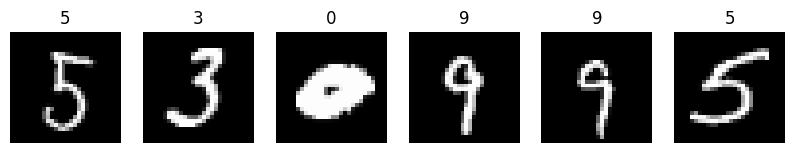

In [12]:
# Preview a few images from the DataLoader
np.set_printoptions(linewidth=200, threshold=784, suppress=True)

examples, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 6, figsize=(10, 2))
for i in range(6):
    axes[i].imshow(examples[i, 0].numpy(), cmap='gray')
    axes[i].set_title(int(labels[i]))
    axes[i].axis('off')
plt.show()

In [13]:
# Define a neural network with 2 hidden layers for Quantization
class MNISTTwoHiddenQuant(nn.Module):
    def __init__(self, input_dim: int, hidden_dim1: int, hidden_dim2: int, num_classes: int):
        super().__init__()
        self.quant = QuantStub()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, num_classes)
        )
        self.dequant = DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.net(x)
        x = self.dequant(x)
        return x

hidden_dim1 = 16
hidden_dim2 = 16
model = MNISTTwoHiddenQuant(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

MNISTTwoHiddenQuant(
  (quant): QuantStub()
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=16, bias=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): ReLU()
    (5): Linear(in_features=16, out_features=10, bias=True)
  )
  (dequant): DeQuantStub()
)


In [14]:
# Train (Float32)
num_epochs = 5  # Reduced for speed, but enough for convergence
log_interval = 100

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for batch_idx, (inputs, targets) in enumerate(train_loader, start=1):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % log_interval == 0:
            print(f"Epoch {epoch} [{batch_idx}/{len(train_loader)}] Loss: {running_loss/log_interval:.4f}")
            running_loss = 0.0

    train_acc = 100.0 * correct / total
    train_accuracies.append(train_acc)
    print(f"Epoch {epoch} training accuracy: {train_acc:.2f}%")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    test_acc = 100.0 * correct / total
    test_accuracies.append(test_acc)
    print(f"Epoch {epoch} test accuracy: {test_acc:.2f}%")

Epoch 1 [100/235] Loss: 1.1839
Epoch 1 [200/235] Loss: 0.4339
Epoch 1 training accuracy: 78.55%
Epoch 1 test accuracy: 90.31%
Epoch 2 [100/235] Loss: 0.3296
Epoch 2 [200/235] Loss: 0.2976
Epoch 2 training accuracy: 91.06%
Epoch 2 test accuracy: 92.10%
Epoch 3 [100/235] Loss: 0.2670
Epoch 3 [200/235] Loss: 0.2673
Epoch 3 training accuracy: 92.36%
Epoch 3 test accuracy: 92.88%
Epoch 4 [100/235] Loss: 0.2406
Epoch 4 [200/235] Loss: 0.2376
Epoch 4 training accuracy: 93.06%
Epoch 4 test accuracy: 92.95%
Epoch 5 [100/235] Loss: 0.2213
Epoch 5 [200/235] Loss: 0.2182
Epoch 5 training accuracy: 93.60%
Epoch 5 test accuracy: 93.65%


In [15]:
# Apply Post-Training Static Quantization
print("Applying quantization...")
model.eval()
# Use 'fbgemm' for x86 or 'qnnpack' for ARM/mobile
model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
torch.quantization.prepare(model, inplace=True)

# Calibrate
print("Calibrating with training data...")
with torch.no_grad():
    for i, (inputs, targets) in enumerate(train_loader):
        if i > 100: break  # Use a subset for calibration
        inputs = inputs.to(device)
        model(inputs)

# Convert to quantized model
torch.quantization.convert(model, inplace=True)
print("Quantization complete.")
print(model)

Applying quantization...
Calibrating with training data...


C:\Users\micha\AppData\Local\Temp\ipykernel_25556\720622670.py:6: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  torch.quantization.prepare(model, inplace=True)


Quantization complete.
MNISTTwoHiddenQuant(
  (quant): Quantize(scale=tensor([0.0255]), zero_point=tensor([17]), dtype=torch.quint8)
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): QuantizedLinear(in_features=784, out_features=16, scale=0.5233570337295532, zero_point=55, qscheme=torch.per_channel_affine)
    (2): ReLU()
    (3): QuantizedLinear(in_features=16, out_features=16, scale=0.44000041484832764, zero_point=41, qscheme=torch.per_channel_affine)
    (4): ReLU()
    (5): QuantizedLinear(in_features=16, out_features=10, scale=0.3081290125846863, zero_point=67, qscheme=torch.per_channel_affine)
  )
  (dequant): DeQuantize()
)


C:\Users\micha\AppData\Local\Temp\ipykernel_25556\720622670.py:17: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  torch.quantization.convert(model, inplace=True)


In [16]:
# Evaluate Quantized Model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
print(f"Quantized Test Accuracy: {100.0 * correct / total:.2f}%")

Quantized Test Accuracy: 93.59%


In [17]:
# Save Quantized Model
os.makedirs("../outputs", exist_ok=True)
pth_path = os.path.join("../outputs", "mnist_2hidden_int8.pth")
torch.save(model.state_dict(), pth_path)
print(f"Saved quantized weights to {pth_path}")

Saved quantized weights to ../outputs\mnist_2hidden_int8.pth


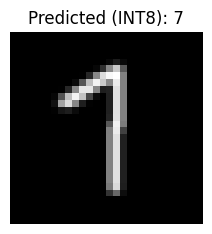

Prediction: 7


In [18]:
# Predict digit from test2.png with INT8 model
img_path = "../test2.png"

if not os.path.exists(img_path):
    print("test2.png not found")
else:
    # Load, convert to grayscale, resize to 20x20
    img_orig = Image.open(img_path).convert("L")
    img_20 = img_orig.resize((20, 20), resample=Image.BILINEAR)

    # Create 28x28 black canvas and center the 20x20 digit
    canvas = Image.new("L", (28, 28), color=0)
    offset = ((28 - 20) // 2, (28 - 20) // 2)
    canvas.paste(img_20, offset)

    # Show processed image
    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(canvas, cmap='gray')
    plt.axis('off')

    # Preprocess for model
    to_tensor = transforms.ToTensor()
    tensor = to_tensor(canvas)
    if tensor.mean().item() > 0.5:
        tensor = 1.0 - tensor
    normalize = transforms.Normalize((0.1307,), (0.3081,))
    tensor = normalize(tensor).unsqueeze(0)

    # Predict
    model.eval()
    with torch.no_grad():
        logits = model(tensor)
        pred = int(logits.argmax(dim=1).item())

    plt.title(f"Predicted (INT8): {pred}")
    plt.show()
    print(f"Prediction: {pred}")